In [1]:
import matplotlib.pyplot as plt 

import numpy as np
import os

import colour

EXAMPLES_RESOURCES_DIRECTORY = "./"
RESOURCES_DIRECTORY = os.path.join(EXAMPLES_RESOURCES_DIRECTORY,
                                   'radiance')

colour.plotting.colour_style()

colour.utilities.describe_environment();

*                                                                             *
*   Interpreter :                                                             *
*       python : 3.7.9 (default, Aug 31 2020, 12:42:55)                       *
*                [GCC 7.3.0]                                                  *
*                                                                             *
*   colour-science.org :                                                      *
*       colour : 0.3.16                                                       *
*                                                                             *
*   Runtime :                                                                 *
*       imageio : 2.9.0                                                       *
*       matplotlib : 3.3.2                                                    *
*       networkx : 2.5                                                        *
*       numpy : 1.19.2                  

## Data

/home/hoseung/.local/lib/python3.7/site-packages/colour/utilities/verbose.py:237: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)


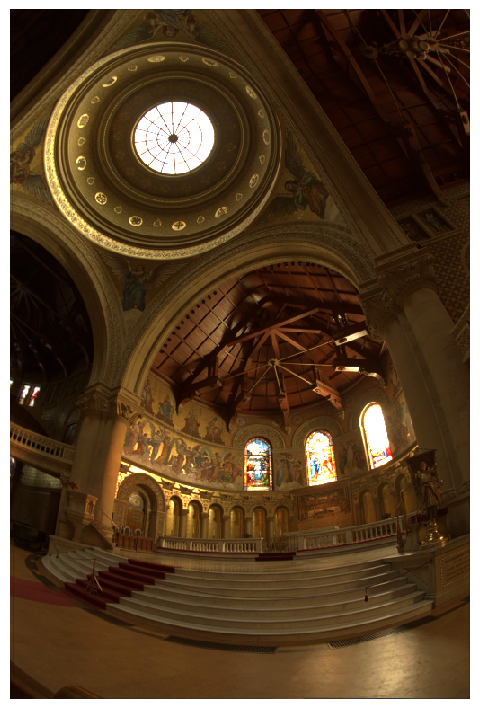

In [2]:
HDRI_IMAGE = colour.read_image(os.path.join(RESOURCES_DIRECTORY, 'memorial.exr'))

SAMPLES = np.linspace(0, 1, 512)
D_SAMPLES = np.dstack((SAMPLES, SAMPLES, SAMPLES))

colour.plotting.plot_image(colour.cctf_encoding(HDRI_IMAGE));

In [3]:
def ACESFilm(x):
    """
    https://knarkowicz.wordpress.com/2016/01/06/aces-filmic-tone-mapping-curve/
    -> is this the original reference? probably not... 
    """
    a = 2.51
    b = 0.03
    c = 2.43
    d = 0.59
    e = 0.14
    return (x*(a*x+b))/(x*(c*x+d)+e)

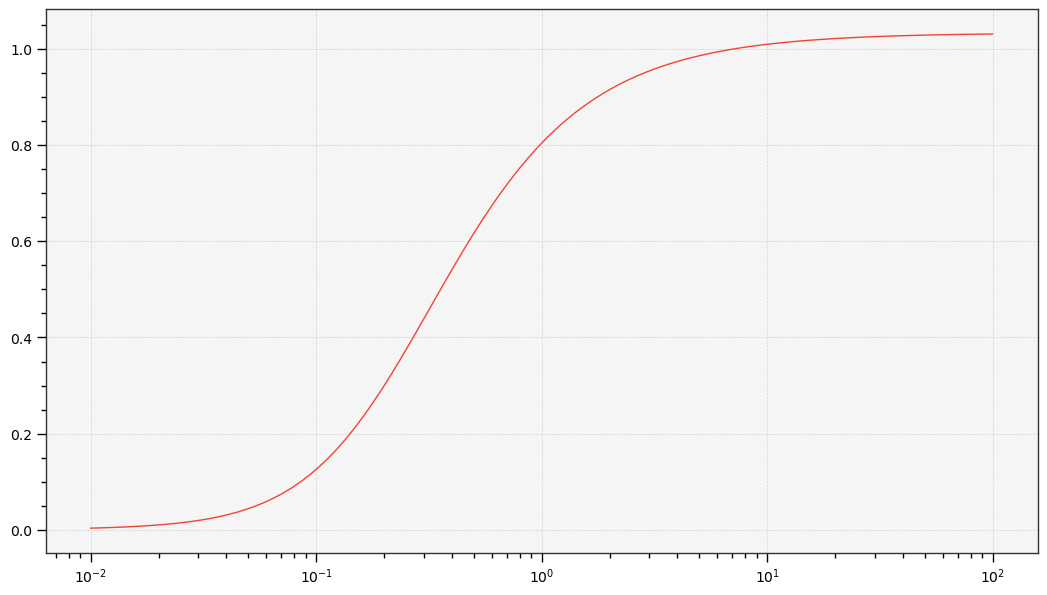

In [4]:
x = np.logspace(-2,2,100)
fig,ax = plt.subplots()
ax.plot(x, ACESFilm(x))
ax.set_xscale('log')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


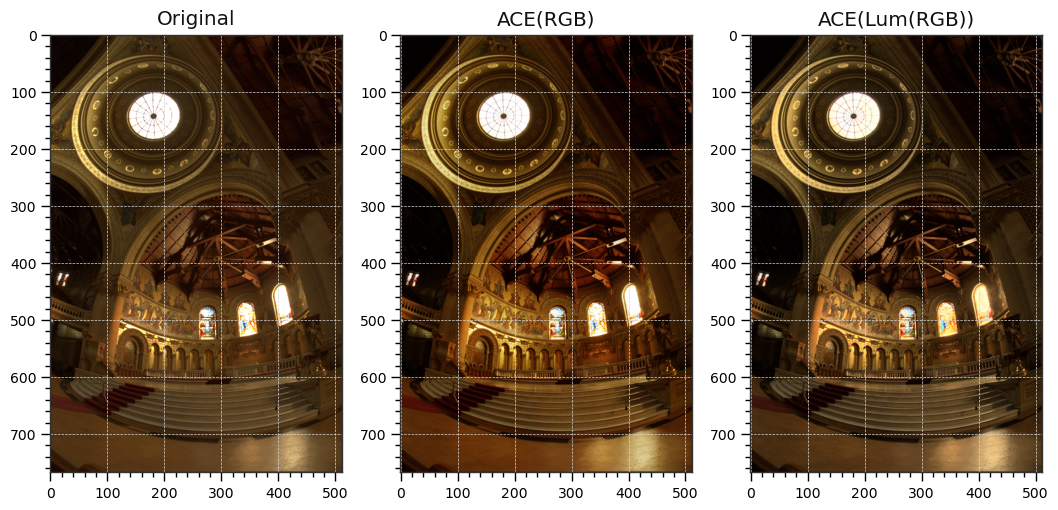

In [5]:
# Color or Luminance?
from colour.models import RGB_COLOURSPACES, RGB_luminance
colorspace = RGB_COLOURSPACES['sRGB']
lum = RGB_luminance(HDRI_IMAGE, colorspace.primaries, colorspace.whitepoint)
lum_ratio = ACESFilm(lum)/lum
mapped = HDRI_IMAGE* np.expand_dims(lum_ratio, -1)
fig, axs = plt.subplots(1,3)
axs[0].imshow(colour.cctf_encoding(HDRI_IMAGE))
axs[0].set_title("Original")
axs[1].imshow(colour.cctf_encoding(ACESFilm(HDRI_IMAGE)))
axs[1].set_title("ACE(RGB)")
axs[2].imshow(colour.cctf_encoding(mapped))
axs[2].set_title("ACE(Lum(RGB))")
plt.show()

# Uncharted

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


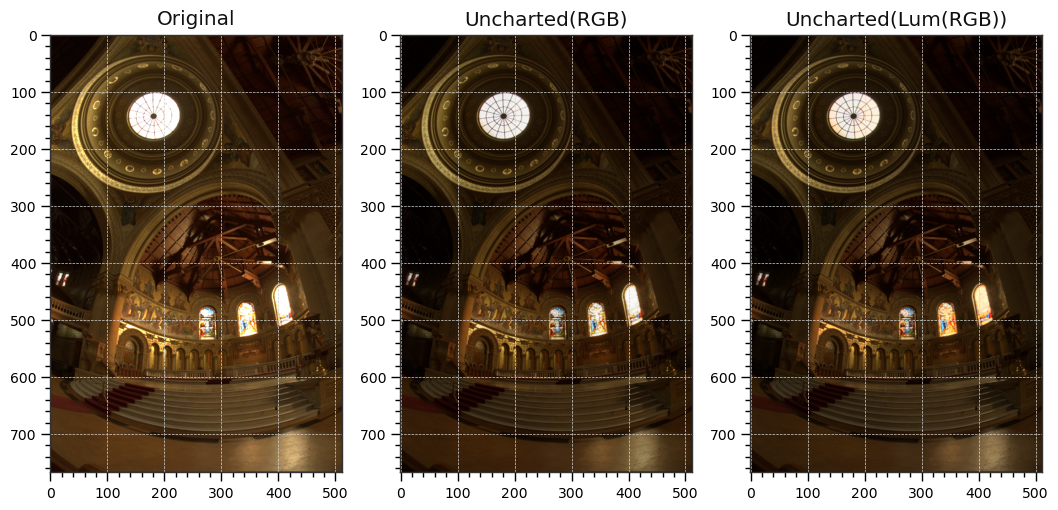

In [6]:
# Uncharted like in http://filmicgames.com/archives/75Jo
def uncharted(x):
    a = 0.22
    b = 0.30
    c = 0.10
    d = 0.20
    e = 0.01
    f = 0.30

    return ((x * (a * x + c * b) + d * e) / (x * (a * x + b) + d * f)) - e / f

def normalized_uncharted(x, hdr_max):
    return uncharted(x) / uncharted(hdr_max)


lum = RGB_luminance(HDRI_IMAGE, colorspace.primaries, colorspace.whitepoint)
lum_ratio = uncharted(lum)/lum
mapped = HDRI_IMAGE* np.expand_dims(lum_ratio, -1)
fig, axs = plt.subplots(1,3)
axs[0].imshow(colour.cctf_encoding(HDRI_IMAGE))
axs[0].set_title("Original")
axs[1].imshow(colour.cctf_encoding(uncharted(HDRI_IMAGE)))
axs[1].set_title("Uncharted(RGB)")
axs[2].imshow(colour.cctf_encoding(mapped))
axs[2].set_title("Uncharted(Lum(RGB))")
plt.show()

# Generic by Timothy Lottes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


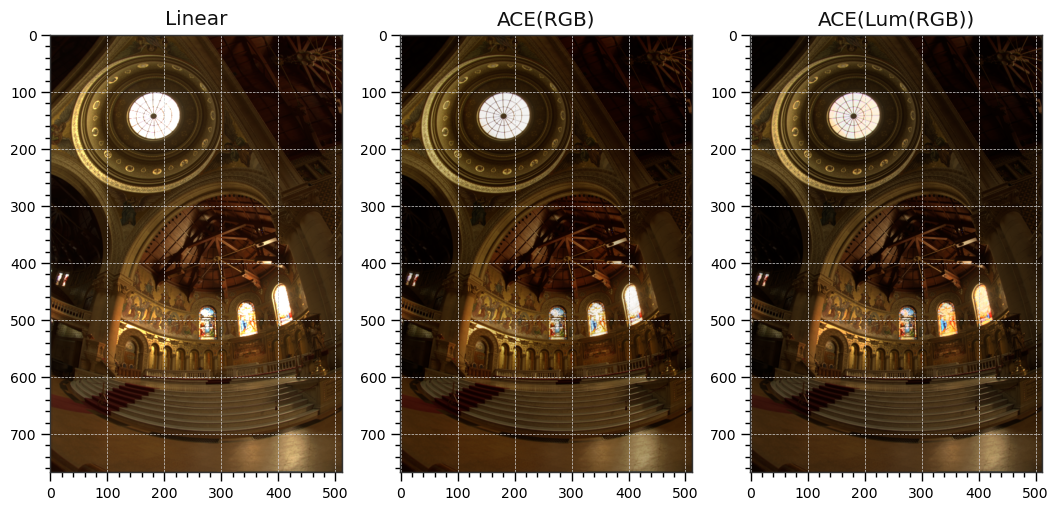

In [7]:
# This part stole from https://github.com/Opioid/tonemapper

# Setting similar to Uncharted:
# contrast = 1.25
# shoulder = 0.975
# mid_in = 0.25
# mid_out = 0.18

class Generic():
    """
    by Timothy Lottes
    https://www.gdcvault.com/play/1023512/Advanced-Graphics-Techniques-Tutorial-Day
    http://32ipi028l5q82yhj72224m8j.wpengine.netdna-cdn.com/wp-content/uploads/2016/03/GdcVdrLottes.pdf
    
    a : contrast
    d : shoulder 
    """
    def __init__(self, hdr_max,a = 1.2, d = 0.97,  mid_in = 0.3, mid_out = 0.18):
        ad = a * d

        midi_pow_a  = pow(mid_in, a)
        midi_pow_ad = pow(mid_in, ad)
        hdrm_pow_a  = pow(hdr_max, a)
        hdrm_pow_ad = pow(hdr_max, ad)
        u = hdrm_pow_ad * mid_out - midi_pow_ad * mid_out
        v = midi_pow_ad * mid_out

        self.a = a
        self.d = d
        self.b = -((-midi_pow_a + (mid_out * (hdrm_pow_ad * midi_pow_a - hdrm_pow_a * v)) / u) / v)
        self.c = (hdrm_pow_ad * midi_pow_a - hdrm_pow_a * v) / u
        self.hdr_max = hdr_max

    def evaluate_single(self, x):
        x = min(x, self.hdr_max)
        z = pow(x, self.a)
        y = z / (pow(z, self.d) * self.b + self.c)

        return y
    
    def evaluate(self, x):
        x[x>self.hdr_max] = self.hdr_max
        z = np.power(x, self.a)
        return z / (np.power(z, self.d) * self.b + self.c)
        
    
gene = Generic(HDRI_IMAGE.max(),1.25,0.975,0.25,0.18)
colorspace = RGB_COLOURSPACES['sRGB']
lum = RGB_luminance(HDRI_IMAGE, colorspace.primaries, colorspace.whitepoint)
lum_ratio = gene.evaluate(lum)/lum
mapped = HDRI_IMAGE* np.expand_dims(lum_ratio, -1)

fig, axs = plt.subplots(1,3)
axs[0].imshow(colour.cctf_encoding(HDRI_IMAGE))
axs[0].set_title("Linear")
axs[1].imshow(colour.cctf_encoding(gene.evaluate(HDRI_IMAGE)))
axs[1].set_title("ACE(RGB)")
axs[2].imshow(colour.cctf_encoding(mapped))
axs[2].set_title("ACE(Lum(RGB))")
plt.show()

# Piecewise Filmic

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


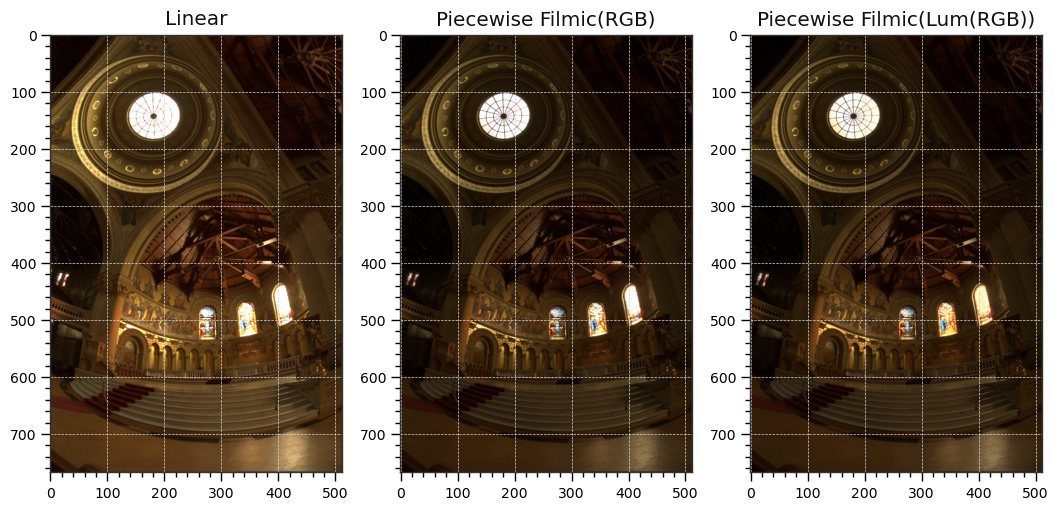

In [9]:
import math
class Piecewise():
    """
    http://filmicworlds.com/blog/filmic-tonemapping-with-piecewise-power-curves/
    """
    
    class Segment():
        offset_x = 0.0
        scale_x = 1.0
        offset_y = 0.0
        scale_y = 1.0
        ln_a = 0.0
        b = 1.0
        
        def evaluate_deprecated(self, x):
            x0 = (x - self.offset_x) * self.scale_x
            y0 = 0.0

            if x0 > 0.0:
                y0 = math.exp(self.ln_a + self.b * math.log(x0))
            
            return y0 * self.scale_y + self.offset_y

        def evaluate(self, x):
            x0 = (x - self.offset_x) * self.scale_x
            y0 = 0.0

            y0 = np.piecewise(x0, 
                              [x0 > 0, x0 <=0],
                              [np.exp(self.ln_a + self.b * np.log(x0)),
                              0])
            
            return y0 * self.scale_y + self.offset_y

        
    def __init__(self, hdr_max, 
                 x0 = 0.25, 
                 y0 = 0.25, 
                 x1 = 0.6, 
                 y1 = 0.6,
                 overshoot_y = 1.5, 
                 overshoot_x_frac=4.0):
        """
        To do :
        Initialization and parameter updating need to be separated
        to avoid creating new instance every time.
        """
        self.segments = [self.Segment(), self.Segment(), self.Segment()]

        overshoot_x = hdr_max * overshoot_x_frac

        norm_x0 = x0 / hdr_max
        norm_x1 = x1 / hdr_max
        norm_overshoot_x = overshoot_x / hdr_max

        self.x0 = norm_x0
        self.x1 = norm_x1
        
        # mid segment
        m, b = Piecewise.as_slope_intercept(norm_x0, norm_x1, y0, y1)

        self.segments[1].offset_x = -(b / m)
        self.segments[1].offset_y = 0.0
        self.segments[1].scale_x = 1.0
        self.segments[1].scale_y = 1.0
        self.segments[1].ln_a = math.log(m)
        self.segments[1].b = 1.0

        # toe segment
        toe_m = m
        ln_a, b = Piecewise.solve_a_b(norm_x0, y0, toe_m)
        self.segments[0].offset_x = 0.0
        self.segments[0].offset_y = 0.0
        self.segments[0].scale_x = 1.0
        self.segments[0].scale_y = 1.0
        self.segments[0].ln_a = ln_a
        self.segments[0].b = b

        # shoulder segment
        shoulder_x0 = (1.0 + norm_overshoot_x) - norm_x1
        shoulder_y0 = (1.0 + overshoot_y) - y1
        
        shoulder_m = m
        ln_a, b = Piecewise.solve_a_b(shoulder_x0, shoulder_y0, shoulder_m)

        self.segments[2].offset_x = 1.0 + norm_overshoot_x
        self.segments[2].offset_y = 1.0 + overshoot_y
        self.segments[2].scale_x = -1.0
        self.segments[2].scale_y = -1.0        
        self.segments[2].ln_a = ln_a
        self.segments[2].b = b

        # Normalize so that we hit 1.0 at white point
        scale = self.segments[2].evaluate(1.0)
        inv_scale = 1.0 / scale

        self.segments[0].offset_y *= inv_scale
        self.segments[0].scale_y *= inv_scale

        self.segments[1].offset_y *= inv_scale
        self.segments[1].scale_y *= inv_scale

        self.segments[2].offset_y *= inv_scale
        self.segments[2].scale_y *= inv_scale
        
        self.hdr_max = hdr_max
        
    def evaluate_deprecated(self, x):
        norm_x = x / self.hdr_max
        
        index = 0 if norm_x < self.x0 else (1 if norm_x < self.x1 else 2)
        
        return self.segments[index].evaluate(norm_x)
    
    def evaluate(self, x):
        norm_x = x / self.hdr_max
        conditions=[norm_x <= self.x0,
                    (norm_x > self.x0) * (norm_x <= self.x1),
                    norm_x > self.x1]
        
        functions = [self.segments[0].evaluate,
                     self.segments[1].evaluate,
                     self.segments[2].evaluate]
        return np.piecewise(norm_x, conditions, functions)

    @staticmethod
    def as_slope_intercept(x0, x1, y0, y1):
        dy = y1 - y0
        dx = x1 - x0

        m = 1.0
        if 0.0 != dx:
            m = dy / dx

        b = y0 - x0 * m

        return m, b
        
    
    @staticmethod
    def solve_a_b(x0, y0, m):
        b = (m * x0) / y0
        ln_a = math.log(y0) - b * math.log(x0)
        return ln_a, b

piec = Piecewise(HDRI_IMAGE.max(),
                 x0 = 0.25, 
                 y0 = 0.25, 
                 x1 = 0.6, 
                 y1 = 0.6,
                 overshoot_y = 1.5, 
                 overshoot_x_frac=4.0) # <- This is going to take place EVERY epoch. 
# Isn't it too much 

colorspace = RGB_COLOURSPACES['sRGB']
lum = RGB_luminance(HDRI_IMAGE, colorspace.primaries, colorspace.whitepoint)
lum_ratio = piec.evaluate(lum)/lum
mapped = HDRI_IMAGE* np.expand_dims(lum_ratio, -1)

fig, axs = plt.subplots(1,3)
axs[0].imshow(colour.cctf_encoding(HDRI_IMAGE))
axs[0].set_title("Linear")
axs[1].imshow(colour.cctf_encoding(piec.evaluate(HDRI_IMAGE)))
axs[1].set_title("Piecewise Filmic(RGB)")
axs[2].imshow(colour.cctf_encoding(mapped))
axs[2].set_title("Piecewise Filmic(Lum(RGB))")
plt.show()

# Generic TMO (Mantiuk & Seidel 2008)

In [159]:
def tmo_mantiuk_seidel(img,s=1, **kwargs):
    """
    s : color_saturation_param
    """
    colorspace = RGB_COLOURSPACES['sRGB']
    lum = RGB_luminance(img, colorspace.primaries, colorspace.whitepoint)
    
    toned = tone_curve(lum, **kwargs) # or np.power(10, tone_curve(lum))
    x = np.logspace(-3,4.5,100)
    plt.plot(x, tone_curve(x, **kwargs))
    ax = plt.gca()
    ax.set_xscale('log')
    plt.show()
    plt.close()
    
    Color_ratio = toned/lum
    modulated = modulation_tf(toned)
    
    return img * np.expand_dims(modulated * Color_ratio**s, -1)

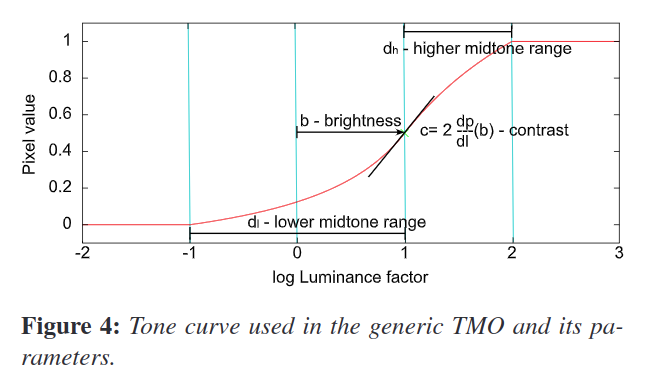

In [96]:
# What are reasonble values???
def tone_curve(lum, b=1.0, c=0.5, dl=1e-1, dh=1e1, gamma=2.2):
    """
    "Generic" tone curve. eq.3 in Mantiuk & Seidel 2008
    
    b : brightness adjustment param
    c : contrast parameter
    dl : lower midtone range
    dh : higher midtone rang
    gamma : display gamma
    """
    lp = np.log10(lum) # L prime
    cp = gamma*c/np.log(10) 
    
    al = (c*dl-1)/dl # contrast compression for shadows
    ah = (c*dh-1)/dh # contrast compression for highlights
    
    conditions=[lp <= b-dl,
               (b-dl < lp) * (lp <= b),
               (b < lp) * (lp <= b+dh),
                lp > b+dh]
    functions=[0,
               lambda lp : 1/2*c*(lp-b)/(1-al*(lp-b))+1/2,
               lambda lp : 1/2*c*(lp-b)/(1+ah*(lp-b))+1/2,
               1]
    
    return np.piecewise(lp, conditions, functions)


def modulation_tf(img):
    """
    'Spatial' modulation operator.
    
    "It specifies which spatial frequencies to amplify or compress 
     and can be thought of as a selectionof low- and high-pass filters"
     
     음.... 
     
    """
    
    return img

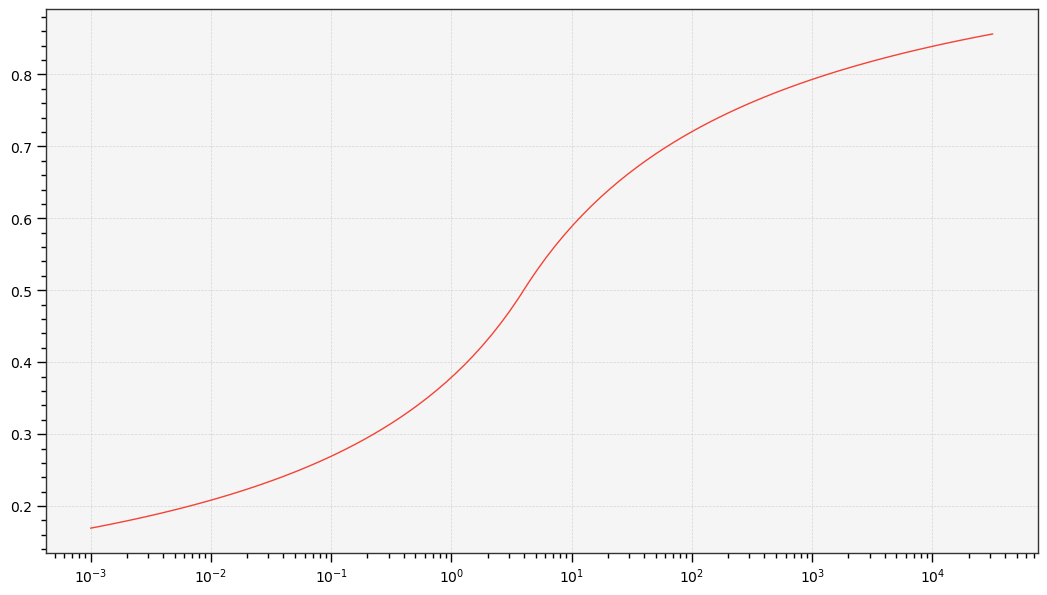

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


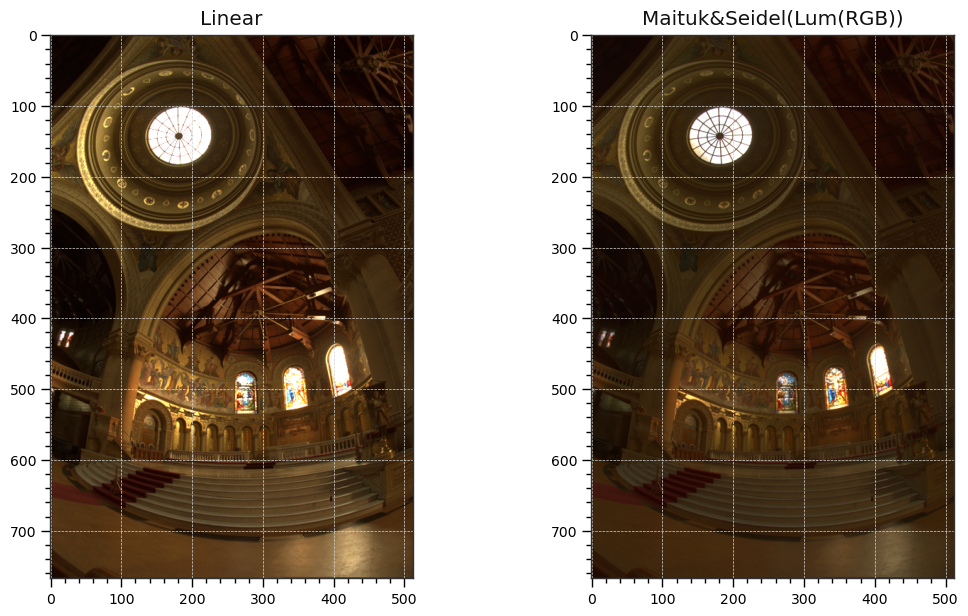

In [177]:
# Values are totally different from the paper..?
mapped = tmo_mantiuk_seidel(HDRI_IMAGE, 
                            s=0.5,
                            b=0.6, 
                            c=0.53, 
                            dl=155.12, 
                            dh=23.46,
                            gamma=2.2)

fig, axs = plt.subplots(1,2)
axs[0].imshow(colour.cctf_encoding(HDRI_IMAGE))
axs[0].set_title("Linear")
axs[1].imshow(colour.cctf_encoding(mapped))
axs[1].set_title("Maituk&Seidel(Lum(RGB))")
plt.show()